# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Problem Statement/Metrics

**The goal of this project is to build a machine learning model to predict whether a customer will response to an offer**

**strategy**

* Exploring and cleaning three datasets
* Combine all three datasets together to make a final table that is ready to build the model
* Build a baseline model for each offer type
* Applying cross validation to each model to make sure that model is legit
* Tunning hyperparameter to improve the model accuracy
* Pick the model with highest accuracy as final model

**metrics**

* Accuracy Score

We want to identify the customer that are willing to response to an offer,so the accuracy should do the job.On the other hand, as the class is not really imbalance, accuracy should be a fine measure for this task.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Data Exploration and Visualization

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# expand to show all columns
pd.set_option('display.max_columns', 500)

In [14]:
# exploring tables and check null values

print(portfolio.isnull().sum())
portfolio.head()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [18]:
portfolio.describe(include='all')

,channels,difficulty,duration,id,offer_type,reward
count,10,10.000000,10.000000,10,10,10.000000
unique,4,NaN,NaN,10,3,NaN
top,"[web, email, mobile, social]",NaN,NaN,3f207df678b143eea3cee63160fa8bed,bogo,NaN
freq,4,NaN,NaN,1,4,NaN
mean,NaN,7.700000,6.500000,NaN,NaN,4.200000
std,NaN,5.831905,2.321398,NaN,NaN,3.583915
min,NaN,0.000000,3.000000,NaN,NaN,0.000000
25%,NaN,5.000000,5.000000,NaN,NaN,2.000000
50%,NaN,8.500000,7.000000,NaN,NaN,4.000000
75%,NaN,10.000000,7.000000,NaN,NaN,5.000000


In [4]:
print(profile.isnull().sum())
profile.head()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [19]:
profile.describe(include='all')

,age,became_member_on,gender,id,income
count,17000.000000,1.700000e+04,14825,17000,14825.000000
unique,NaN,NaN,3,17000,NaN
top,NaN,NaN,M,0485b8cb0bfc4d938895bbd6d8cbd7df,NaN
freq,NaN,NaN,8484,1,NaN
mean,62.531412,2.016703e+07,NaN,NaN,65404.991568
std,26.738580,1.167750e+04,NaN,NaN,21598.299410
min,18.000000,2.013073e+07,NaN,NaN,30000.000000
25%,45.000000,2.016053e+07,NaN,NaN,49000.000000
50%,58.000000,2.017080e+07,NaN,NaN,64000.000000
75%,73.000000,2.017123e+07,NaN,NaN,80000.000000


In [5]:
print(transcript.isnull().sum())
transcript.head()

event     0
person    0
time      0
value     0
dtype: int64


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.describe(include='all')

,event,person,time,value
count,306534,306534,306534.000000,306534
unique,4,17000,NaN,5121
top,transaction,94de646f7b6041228ca7dec82adb97d2,NaN,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
freq,138953,51,NaN,14983
mean,NaN,NaN,366.382940,NaN
std,NaN,NaN,200.326314,NaN
min,NaN,NaN,0.000000,NaN
25%,NaN,NaN,186.000000,NaN
50%,NaN,NaN,408.000000,NaN
75%,NaN,NaN,528.000000,NaN


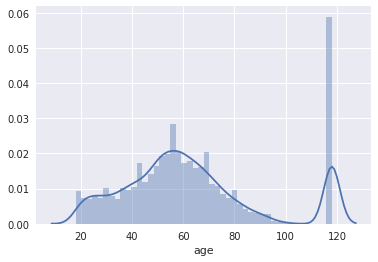

In [35]:
# age distribution
sns.distplot(profile['age'])

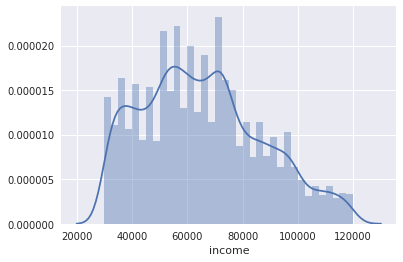

In [37]:
# income distribution
sns.distplot(profile['income'].dropna())

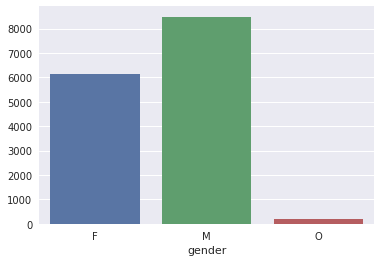

In [46]:
# gender distribution
sns.barplot(profile.groupby(['gender'])['id'].count().index,profile.groupby(['gender'])['id'].count().values)

# Data Preprocessing

In [47]:
# drop null values

profile = profile.dropna()

In [48]:
# one-hot encoding for categorical variables

portfolio['channels_web'] = np.where(portfolio['channels'].astype(str).str.contains('web'),1,0)
portfolio['channels_email'] = np.where(portfolio['channels'].astype(str).str.contains('email'),1,0)
portfolio['channels_mobile'] = np.where(portfolio['channels'].astype(str).str.contains('mobile'),1,0)
portfolio['channels_social'] = np.where(portfolio['channels'].astype(str).str.contains('social'),1,0)

portfolio['offer_bogo'] = np.where(portfolio['offer_type'].str.contains('bogo'),1,0)
portfolio['offer_informational'] = np.where(portfolio['offer_type'].str.contains('informational'),1,0)
portfolio['offer_discount'] = np.where(portfolio['offer_type'].str.contains('discount'),1,0)

In [49]:
# one-hot encoding for categorical variables

profile['became_member_on_year'] = profile['became_member_on'].apply(lambda x: pd.to_numeric(str(x)[:4]))
profile['became_member_on_month'] = profile['became_member_on'].apply(lambda x: pd.to_numeric(str(x)[5:7]))
profile['became_member_on_day'] = profile['became_member_on'].apply(lambda x: pd.to_numeric(str(x)[7:]))

profile['gender_M'] = np.where(profile['gender'] == 'M',1,0)
profile['gender_F'] = np.where(profile['gender'] == 'F',1,0)
profile['gender_O'] = np.where(profile['gender'] == 'O',1,0)

In [50]:
# fucntion to extract offer_id from dict
def extract_offer_id(x):
    try:
        return x['offer id'] 
    except KeyError:
        try:
            return x['offer_id']
        except:
            return None

In [51]:
# function to extract amount from dict
def extract_amount(x):
    try:
        return x['amount'] 
    except KeyError:
        return None

In [52]:
# create offer_id and amount columns
transcript['offer_id'] = transcript['value'].apply(extract_offer_id)
transcript['amount'] = transcript['value'].apply(extract_amount)
transcript = transcript.drop(columns = ['value'])

In [53]:
# add offer_id to each transaction
transcript = transcript.sort_values(by=['person','time'])
transcript['offer_id'] = transcript['offer_id'].ffill()
transcript = transcript.groupby(['person','offer_id']).agg({'event': lambda x:','.join(x),'amount':'sum'}).reset_index()

In [54]:
# merge portfolio, profile and transcript
transaction = pd.merge(transcript,portfolio,how = 'left', left_on = 'offer_id', right_on = 'id').drop(columns='id')
customer_trans = pd.merge(transaction,profile,how = 'left', left_on = 'person',right_on = 'id').drop(columns='id')

In [55]:
# create response variable 1 if response to offer, otherwise 0
customer_trans['response_to_offer'] = np.where((customer_trans['event'].str.contains('offer received'))&\
               (customer_trans['amount']==0)&\
               (~customer_trans['event'].str.contains('offer completed')),0,1)

In [56]:
# drop redundant columns
customer_trans = customer_trans.drop(columns=['person','offer_id','event','channels','offer_type','became_member_on','gender'])

In [57]:
# drop null values
customer_trans =customer_trans.dropna()

# Modeling and Validation

## 1. BOGO Offer Model

In [79]:
# function to make prediction for bogo offer
def bogo_model(df):
    bogo_trans = df[df['offer_bogo']==1].drop(columns = ['offer_informational','offer_discount'])
    X_bogo = bogo_trans.drop(columns=['response_to_offer','amount'])
    Y_bogo = bogo_trans['response_to_offer']
    x_train_bogo,x_test_bogo,y_train_bogo,y_test_bogo = train_test_split(X_bogo,Y_bogo,test_size = 0.2,random_state = 0)
    
    rf_model = RandomForestClassifier(n_estimators = 200,random_state = 0)
    rf_model.fit(x_train_bogo,y_train_bogo)
    y_pred_bogo = rf_model.predict(x_test_bogo)
    
    return bogo_trans,X_bogo,Y_bogo,x_train_bogo,x_test_bogo,y_train_bogo,y_test_bogo,y_pred_bogo,rf_model

In [80]:
bogo_trans,X_bogo,Y_bogo,x_train_bogo,x_test_bogo,y_train_bogo,y_test_bogo,y_pred_bogo,rf_model = bogo_model(customer_trans)

In [81]:
# function to plot accuracy score and cross validation score
def plot_result(rf_model,y_test,y_pred,X,Y):
    # get accuracy
    ac = accuracy_score(y_test, y_pred)
    # 5-fold cross validation
    cv = cross_val_score(rf_model,X, Y, cv = 5).mean()
    
    df = pd.DataFrame({'measure':['accuracy','cross_validation'],'score':[ac,cv]},
                       index=[0,1],columns=['measure','score'])
    
    # plot
    sns.set()
    ax = sns.barplot(x='measure',y='score',data=df)
    ax.set_ylim(0,1)
    for i, v in enumerate(round(df.score,3)):
        ax.text(i - 0.1, v + 0.01, str(v), color='red')

    plt.show()

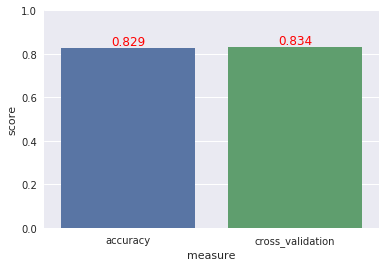

In [82]:
plot_result(rf_model,y_test_bogo,y_pred_bogo,X_bogo,Y_bogo)

## 2. Discount Offer Model

In [83]:
# function to make prediction for discount offer
def discount_model(df):
    discount_trans = df[df['offer_discount']==1].drop(columns = ['offer_informational','offer_bogo'])
    X_discount = discount_trans.drop(columns=['response_to_offer','amount'])
    Y_discount = discount_trans['response_to_offer']
    x_train_discount,x_test_discount,y_train_discount,y_test_discount = train_test_split(X_discount,Y_discount,test_size = 0.2,random_state = 0)
    
    rf_model = RandomForestClassifier(n_estimators = 200,random_state = 0)
    rf_model.fit(x_train_discount,y_train_discount)
    y_pred_discount = rf_model.predict(x_test_discount)
    
    return discount_trans,X_discount,Y_discount,x_train_discount,x_test_discount,y_train_discount, y_test_discount,y_pred_discount,rf_model

In [84]:
discount_trans,X_discount,Y_discount,x_train_discount,x_test_discount,y_train_discount, y_test_discount,y_pred_discount,rf_model = discount_model(customer_trans)

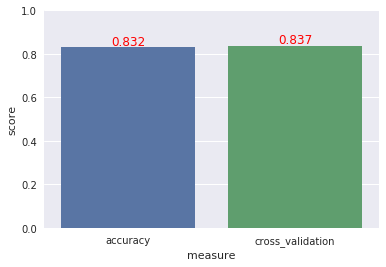

In [85]:
plot_result(rf_model,y_test_discount,y_pred_discount,X_discount,Y_discount)

## 3. Informational Offer Model

In [86]:
# function to make prediciton for informational offer
def informational_model(df):
    informational_trans = df[df['offer_informational']==1].drop(columns = ['offer_bogo','offer_discount'])
    X_informational = informational_trans.drop(columns=['response_to_offer','amount'])
    Y_informational = informational_trans['response_to_offer']
    x_train_informational,x_test_informational,y_train_informational,y_test_informational = train_test_split(X_informational,Y_informational,
                                                                  test_size = 0.2,random_state = 0)
    
    rf_model = RandomForestClassifier(n_estimators = 200,random_state = 0)
    rf_model.fit(x_train_informational,y_train_informational)
    y_pred_informational = rf_model.predict(x_test_informational)
    
    return informational_trans,X_informational,Y_informational,x_train_informational,x_test_informational,y_train_informational,y_test_informational,y_pred_informational,rf_model

In [87]:
informational_trans,X_informational,Y_informational,x_train_informational,x_test_informational,y_train_informational,y_test_informational,y_pred_informational,rf_model = informational_model(customer_trans)

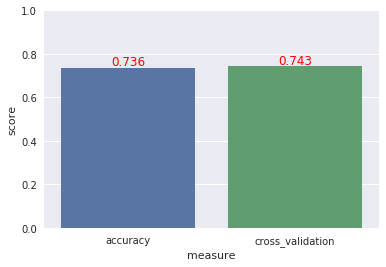

In [88]:
plot_result(rf_model,y_test_informational,y_pred_informational,X_informational,Y_informational)

# Refinement

We want to run apply gridsearch to the model in order to tune hyperparameter and improve model's accuracy

**parameters**
* n_estimarotors:
    * 100
    * 300
* max_features type:
    * auto
    * sqrt
    * log2

In [105]:
# function to tune hyperparameters through gridsearch
def grid_search(x_train,y_train,x_test):
    parameters = {'n_estimators':[100,300],
                  'max_features': ['auto', 'sqrt', 'log2']}
    
    grid = GridSearchCV(rf_model, parameters, cv=5)
    grid.fit(x_train,y_train)
    grid_pred = grid.predict(x_test)
    
    return grid_pred

In [106]:
# function to plot accuracy score with and withou hyperparameter tuning
def plot_result_grid(X,Y,x_train,x_test,y_train,y_test,y_pred,rf_model):
    # get accuracy
    ac = accuracy_score(y_test, y_pred)
    # gridsearch
    grid_pred = grid_search(x_train,y_train,x_test)
    grid_score = accuracy_score(y_test, grid_pred)
    
    df = pd.DataFrame({'measure':['accuracy','accuracy_grid_search'],'score':[ac,grid_score]},
                       index=[0,1],columns=['measure','score'])
    
    # plot
    sns.set()
    ax = sns.barplot(x='measure',y='score',data=df)
    ax.set_ylim(0,1)
    for i, v in enumerate(round(df.score,3)):
        ax.text(i - 0.1, v + 0.01, str(v), color='red')

    plt.show()

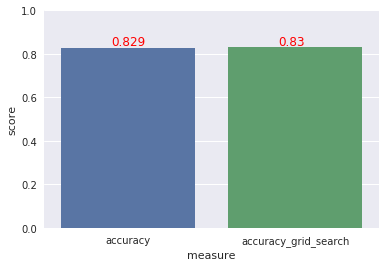

In [107]:
# bogo offer model with gridsearch
plot_result_grid(X_bogo,Y_bogo,x_train_bogo,x_test_bogo,y_train_bogo,y_test_bogo,y_pred_bogo,rf_model)

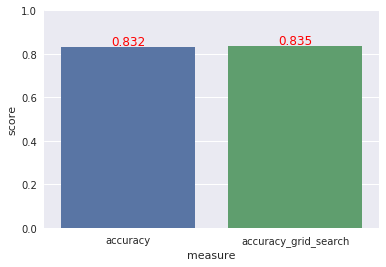

In [108]:
# discount offer model with gridsearch
plot_result_grid(X_discount,Y_discount,x_train_discount,
                 x_test_discount,y_train_discount, y_test_discount,y_pred_discount,rf_model)

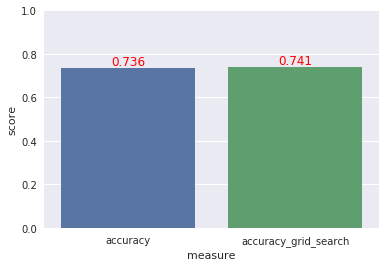

In [109]:
# informational offer model with gridsearch
plot_result_grid(X_informational,Y_informational,x_train_informational,
                 x_test_informational,y_train_informational,y_test_informational,y_pred_informational,rf_model)

## Results

The accuracy of each model has been improved after tunning hyperparameter

* BOGO Offer Model: 0.829 -> 0.83
* Discount Offer Model: 0.832 -> 0.835
* Informational Offer Model: 0.736 -> 0.741

# Conclusion

**The challage part of this task is to define the effectiveness of the offer as there are four different scenarios**

    1. Response to offer:
       (a) offer received -> offer viewed -> transaction -> offer completed
       (b) user receive offer but complete withou open it
    2. No response to offer:
       (a) offer received -> offer viewed
       (b) offer received 
       
In a nutshell, building a model to predict whether the customer will resposne to an offer or not is just a part of offer optimization problem. Implementing a recommender system might be another good solution to have a better understanding of our customer.